In [2]:
import glob
import logging
import os
import sys

import numpy as np
import fitsio

import pyds9

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import fpga
from fpga import geom

from testing import ccdProcedures


/home/pfs/hostdevel/fullAnaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [35]:
d = pyds9.DS9()

In [ ]:
biasNames = glob.glob('/data/pfs/2015-12-03/PFSA00612[3-9]92.fits')
biasNames.extend(glob.glob('/data/pfs/2015-12-03/PFSA00613*92.fits'))
sbias1, meds1  = geom.clippedStack(biasNames)

In [ ]:
biasNames2 = glob.glob('/data/pfs/2015-12-03/PFSA00616[2-6]92.fits')
sbias2, meds2 = geom.clippedStack(biasNames2)

In [ ]:
biasNames3 = glob.glob('/data/pfs/2015-12-03/PFSA00616[8-9]92.fits')
biasNames3.extend(glob.glob('/data/pfs/2015-12-03/PFSA00617[0-3]92.fits'))
sbias3, meds3 = geom.clippedStack(biasNames3)

In [ ]:
biasNames4 = glob.glob('/data/pfs/2015-12-03/PFSA00623[7-9]92.fits')
biasNames4.extend(glob.glob('/data/pfs/2015-12-03/PFSA00624[0-1]92.fits'))
sbias4, meds4 = geom.clippedStack(biasNames4)

In [4]:
biasNames5 = glob.glob('/data/pfs/2015-12-06/PFSA00700*92.fits')
biasNames5.extend(glob.glob('/data/pfs/2015-12-06/PFSA00701[0-6]92.fits '))
sbias5, meds5 = geom.clippedStack(biasNames5)

In [77]:
biasNames7 = glob.glob('/data/pfs/2015-12-04/PFSA00630[3-9]92.fits')
biasNames7.extend(glob.glob('/data/pfs/2015-12-04/PFSA00631[0-9]92.fits'))
biasNames7.sort()
sbias7, meds7 = geom.clippedStack(biasNames7)

In [12]:
biasNames8 = glob.glob('/data/pfs/2015-12-18/PFSA00718[0-9]92.fits')
#biasNames8.extend(glob.glob('/data/pfs/2015-12-18/PFSA00631[0-9]92.fits'))
biasNames8.sort()
sbias8, meds8 = geom.clippedStack(biasNames8)

In [5]:
biasNames9 = glob.glob('/data/pfs/2015-12-21/PFSA00723[6-9]92.fits')
biasNames9.extend(glob.glob('/data/pfs/2015-12-21/PFSA00724[0-4]92.fits'))
biasNames9.sort()
sbias9, meds9 = geom.clippedStack(biasNames9)

In [8]:
qeList = glob.glob('/data/pfs/2015-12-21/PFSA00722*92.fits')
qeList.extend(glob.glob('/data/pfs/2015-12-21/PFSA00721992.fits'))
qeList.sort()          

In [9]:
def qeStats1(fname):
    _, _, ret = ccdProcedures.imStats(fname)
    ccdProcedures.printStats(ret)
    
    hdr = fitsio.read_header(fname)

    exptime = hdr['EXPTIME']
    wavelength = hdr['qe.wave']
    energy = hdr['qe.energy']
    flux = energy / exptime
    
    print ""
    return ret, hdr

In [10]:
stats, hdr = qeStats1(qeList[3])

amp readnoise readnoiseM  gain  gainM    signal    bias sig^0.5 shotnoise shotnoiseM noise dn/s

0        2.62      2.26   2.24   2.33   3916.00  982.00   62.58     41.84     40.98   5.86 783.2
1        2.62      2.20   2.38   2.40   3860.00 1040.00   62.13     40.26     40.06   6.24 772.0
2        2.10      2.25   2.29   2.35   3907.00 1041.00   62.51     41.34     40.77   4.79 781.4
3        2.10      2.26   2.33   2.41   3986.00  970.00   63.13     41.34     40.68   4.89 797.2
4        2.10      2.20   2.29   2.39   3915.00 1099.00   62.57     41.34     40.45   4.80 783.0
5        2.62      2.48   2.41   2.35   4007.00 1066.00   63.30     40.79     41.25   6.31 801.4
6        2.62      2.55   2.36   2.40   3948.00 1064.00   62.83     40.92     40.52   6.18 789.6
7        2.62      2.19   2.34   2.45   3791.00 1076.00   61.57     40.26     39.35   6.13 758.2



In [ ]:
%pdb on 
reload(geom)

#fexp = geom.Exposure('/data/pfs/2015-12-22/PFSA00729292.fits')
fname = '/data/pfs/2016-04-06/PFJA00742291.fits'
fexp = geom.Exposure(fname)

_, _, ret = ccdProcedures.imStats(fname)
ccdProcedures.printStats(ret)

bias = None
ampImages, overscanImages = fexp.biasSubtract(bias)

for i in range(len(ampImages)):
    print "%d: %0.1f, %0.1f" % (i, np.median(ampImages[i]), np.median(overscanImages[i]))

d.set('frame 1')
d.set_np2arr(np.hstack(ampImages))
d.set('scale zscale')
#d.set('zoom fit')

d.set('frame 2')
d.set_np2arr(np.hstack(overscanImages))
d.set('scale zscale')

d.set('frame 3')
d.set_np2arr(fexp.image)
d.set('scale zscale')

d.set('frame 4')
d.set_np2arr(sbias8)
d.set('scale zscale')

d.set('frame 1')



Automatic pdb calling has been turned ON


IndexError: cannot do a non-empty take from an empty axes.

> /home/pfs/hostdevel/fullAnaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py(124)take()
    123         return _wrapit(a, 'take', indices, axis, out, mode)
--> 124     return take(indices, axis, out, mode)
    125 

ipdb> up
> /home/pfs/hostdevel/fullAnaconda/lib/python2.7/site-packages/numpy/lib/function_base.py(3385)_percentile()
   3384 
-> 3385         x1 = take(ap, indices_below, axis=axis) * weights_below
   3386         x2 = take(ap, indices_above, axis=axis) * weights_above

ipdb> up
> /home/pfs/hostdevel/fullAnaconda/lib/python2.7/site-packages/numpy/lib/function_base.py(2997)_ureduce()
   2996 
-> 2997     r = func(a, **kwargs)
   2998     return r, keepdim

ipdb> up
> /home/pfs/hostdevel/fullAnaconda/lib/python2.7/site-packages/numpy/lib/function_base.py(3268)percentile()
   3267                     overwrite_input=overwrite_input,
-> 3268                     interpolation=interpolation)
   3269     if keepdims:

ipdb> up
> /home/pfs/ics_xcu_fpga/python/testing/c

In [19]:
reload(geom)
reload(ccdProcedures)

pfiles = []
pfiles.extend(glob.glob('/data/pfs/2015-12-03/PFSA00618*92.fits'))
pfiles.extend(glob.glob('/data/pfs/2015-12-03/PFSA00619[0-7]92.fits'))
pfiles.extend(glob.glob('/data/pfs/2015-12-03/PFSA00624[2-8]92.fits'))

# Low flats
lffiles0 = glob.glob('/data/pfs/2015-12-04/PFSA00632[4-7]92.fits')
lffiles0.extend(glob.glob('/data/pfs/2015-12-04/PFSA0063[3-7]*92.fits'))
lffiles0.extend(glob.glob('/data/pfs/2015-12-04/PFSA00638[0-8]92.fits'))

lffiles1 = glob.glob('/data/pfs/2015-12-04/PFSA00640992.fits')
lffiles1.extend(glob.glob('/data/pfs/2015-12-04/PFSA0064[1-8]*92.fits'))

lffiles2 = glob.glob('/data/pfs/2015-12-04/PFSA00650[1-9]92.fits')
lffiles2.extend(glob.glob('/data/pfs/2015-12-04/PFSA0065[1-7]*92.fits'))
    
allLflats = lffiles0 + lffiles1 + lffiles2 
allLflats.sort()
all2sFlats = [f for f in allLflats if fitsio.read_header(f)['EXPTIME'] == 2]

# Trip some noisier images
all2sFlats = all2sFlats[4:]

# Bright flats:
bffiles = glob.glob('/data/pfs/2015-12-03/PFSA00619[9]*92.fits')
bffiles.extend(glob.glob('/data/pfs/2015-12-03/PFSA0062[012]*92.fits'))
bffiles.extend(glob.glob('/data/pfs/2015-12-03/PFSA00623[0-2]*92.fits'))

pfiles = bffiles[:]
pfiles.sort()

flstats = []
for f in sbias8:
    _, _, stat1 = ccdProcedures.imStats(f)
    flstats.append(stat1[3])

IndexError: too many indices for array

In [5]:
list([f['noise'] for f in flstats])

[4.6520181,
 4.6520181,
 4.7713008,
 4.7713008,
 4.8309422,
 4.8309422,
 4.7713008,
 3.9916766,
 6.4151945,
 4.8309422,
 4.7713008,
 4.8309422,
 4.8309422,
 4.8309422,
 4.8309422,
 4.8309422,
 4.8309422,
 4.8309422]

In [19]:
_f, _pl = plt.subplots(nrows=5, figsize=(8,15))
fits = []
cm = plt.get_cmap('gist_rainbow')
colors = [cm(i/8.0) for i in range(8)]
print ""
for i in range(8):
    pos_w = (da['exptime'][i,0] > 0) & (da['exptime'][i,0] < 160)
    x = da['exptime'][pos_w,i]
    y = da['signal'][pos_w,i]
    x_ii = np.argsort(x)
    x = x[x_ii]
    y = y[x_ii]
    fit = np.polyfit(x,y,2)
    _pl[0].plot(x, y-np.polyval(fit, x), '+', color=colors[i])
    #_pl[0].plot(x, y-np.polyval(fit, x), '-', color=colors[i], alpha=0.1)
    _pl[0].set_ylabel('signal - fit line')
    _pl[0].set_xlabel('exposure time (0.25mm slit)')

    _pl[1].plot(x, y, '+', color=colors[i])
    _pl[1].plot(x, y, '-', color=colors[i], alpha=0.1)
    _pl[1].set_ylabel('signal')
    _pl[1].set_xlabel('exposure time (0.25mm slit)')

    bias_ii = np.argsort(da['bias'][i])
    bias0 = da[:,i,2][0]
    _pl[2].plot(da['bias'][i]-bias0, '+', color=colors[i])
    _pl[2].plot(da['bias'][i]-bias0, '-', color=colors[i], alpha=0.1)
    _pl[2].set_ylabel('overscan - overscan[exp#0]')
    _pl[2].set_xlabel('exposure #')

    pa0temps = da['preamptemp'][i]
    ccd0temps = da['ccd0temp'][i]
    _pl[3].plot(ccd0temps-ccd0temps[0], 'x')
    _pl[3].plot(ccd0temps-ccd0temps[0], '-', alpha=0.1)
    _pl[3].set_ylabel('ccd temp - temp[exp#0]')
    _pl[3].set_xlabel('exposure #')

    _pl[4].plot(pa0temps-pa0temps[0], '+')
    _pl[4].plot(pa0temps-pa0temps[0], '-', alpha=0.1)
    _pl[4].set_ylabel('preamp temp - temp[exp#0]')
    _pl[4].set_xlabel('exposure #')
    
    
_pl[0].set_title('%s to %s' % (os.path.split(pfiles[0])[-1],
                               os.path.split(pfiles[-1])[-1]))
_f.tight_layout()

<IPython.core.display.Javascript object>

NameError: name 'da' is not defined

In [ ]:
reload(geom)
reload(ccdProcedures)

ffiles = glob.glob('/data/pfs/2015-12-04/PFSA00673[56]92.fits')
ffiles.extend(glob.glob('/data/pfs/2015-12-04/PFSA00675[78]92.fits'))
#ffiles = all2sFlats
fbias = sbias7

colCTEs, rowCTEs, allNormedCols, allNormedOsCols, allNormedRows, allNormedOsRows = \
     ccdProcedures.CTEStats(ffiles, fbias)

In [ ]:
ff, pl = plt.subplots(nrows=5, ncols=1, figsize=(10,16))
for i in range(8):
    pl[0].plot(allNormedCols[i][:,-1])
    pl[0].set_title('last active col, %d %0.1fs flats' % (len(ffiles), 
                                                          fitsio.read_header(ffiles[0])['EXPTIME']))
    pl[1].plot(allNormedOsCols[i][:,0])
    pl[1].set_title('first overscan col')
    pl[2].plot(allNormedRows[i][-2,:])
    pl[2].set_title('last-2 active row')
    pl[3].plot(allNormedRows[i][-1,:])
    pl[3].set_title('last active row')
    pl[4].plot(allNormedOsRows[i][0,:])
    pl[4].set_title('first overscan row')
    
ff.tight_layout()

In [ ]:
ff.savefig('/home/pfs/CTElines-1k.pdf')

In [ ]:
pfiles = glob.glob('/data/pfs/2015-12-05/PFSA00*92.fits')
pfiles.extend(glob.glob('/data/pfs/2015-12-04/PFSA00658[3-9]92.fits'))
pfiles.extend(glob.glob('/data/pfs/2015-12-04/PFSA00659*92.fits'))
pfiles.extend(glob.glob('/data/pfs/2015-12-04/PFSA006[67]*92.fits'))
pfiles.sort()

dat = np.zeros((len(pfiles), 3+8*2))

for i, f in enumerate(pfiles):
    exp = geom.Exposure(f)
    im = exp.image
    hdr = exp.header
    exptime = hdr['EXPTIME']
    
    print "=========== %s %s %4d %0.2f" % (os.path.split(f)[-1],
                                           hdr['IMAGETYP'], exptime, 
                                           float(hdr['temp.ccd0']))
    
    ret = ccdProcedures.imStats(exp)
    geom.printStats(ret[-1])
    dat[i,0] = exptime
    dat[i,1] = float(hdr['temp.pa'])
    dat[i,2] = float(hdr['temp.ccd0'])
    dat[i,3:3+8] = ret[-1]['signal']
    dat[i,3+8:3+16] = ret[-1]['bias']
    print

<IPython.core.display.Javascript object>


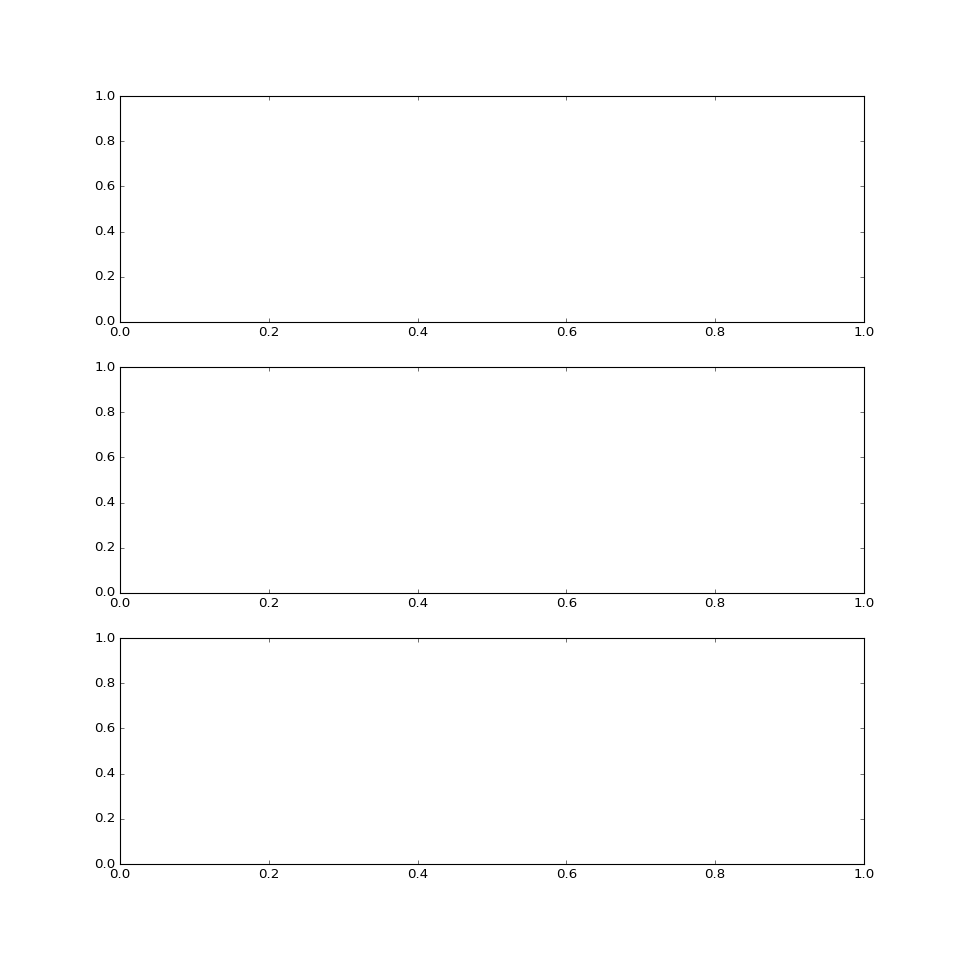

NameError: name 'dat' is not defined

In [18]:
ff, pl = plt.subplots(nrows=3, figsize=(12,12))
linfits = []
imNum = np.arange(len(dat))
for i in range(8):
    w_bias = dat[:,0] == 0
    w_keep = dat[:,0] >= 0
    
    #x = d[w_keep,0]
    imId = imNum[w_keep]
    paTemp = dat[w_keep,1]
    ccdTemp = dat[w_keep,2]
    biasLevel = dat[w_keep,i+3+8]
    # linfits.append(np.polyfit(x, y, 2))
    # resid = y - np.polyval(linfits[-1], x)
    pl[0].plot(imId[w_bias], biasLevel[w_bias]-biasLevel[0], '+')
    pl[0].plot(imId[w_bias != True], biasLevel[w_bias != True]-biasLevel[0], 'x', color='r')
    pl[1].plot(imId[w_bias], paTemp[w_bias], '+')
    pl[1].plot(imId[w_bias!=True], paTemp[w_bias!=True], 'x', color='red')
    pl[2].plot(imId[w_bias], ccdTemp[w_bias], '+')
    pl[2].plot(imId[w_bias!=True], ccdTemp[w_bias!=True], 'x', color='red')
    
pl[0].set_ylabel('overscan - overscan[#0], cnts')
pl[0].set_title('groups of 20 biases + 2 flats, separated by 30 min (#220 by 6 hours).')
pl[1].set_ylabel('preamp temp, K')
pl[2].set_ylabel('ccd0 temp, K')
    
ff.tight_layout()


In [ ]:
ff.savefig('/home/pfs/bias_offsets.pdf')

In [ ]:
reload(geom)
#ret = geom.flatStats('/data/pfs/2015-12-03/PFSA00629792.fits', '/data/pfs/2015-12-03/PFSA00629892.fits')
fpairs = (('/data/pfs/2015-12-03/PFSA00624292.fits', '/data/pfs/2015-12-03/PFSA00624392.fits'),
          ('/data/pfs/2015-12-03/PFSA00619492.fits', '/data/pfs/2015-12-03/PFSA00619592.fits'),
          ('/data/pfs/2015-12-04/PFSA00664792.fits', '/data/pfs/2015-12-04/PFSA00664892.fits'),
          ('/data/pfs/2015-12-04/PFSA00669192.fits', '/data/pfs/2015-12-04/PFSA00669292.fits'),
          ('/data/pfs/2015-12-05/PFSA00680192.fits', '/data/pfs/2015-12-05/PFSA00680292.fits'),
          ('/data/pfs/2015-12-05/PFSA00695992.fits', '/data/pfs/2015-12-05/PFSA00696092.fits'),
         )

for fp in fpairs:
    hdr = fitsio.read_header(fp[0])
    ret = ccdProcedures.flatStats(*fp)
    print "============ %s OD=%0.1f OG=%0.1f" % (fp[0],
                                                 hdr['bias.CH0.OD'],
                                                 hdr['bias.CH0.OG'])
    ccdProcedures.printStats(ret[-1])
    print

In [7]:

d.set('frame 1')
d.set('scale zscale')
d.set_np2arr(sbias)

ampIms, osIms = geom.splitImage(sbias)
ampIm = np.hstack([ai - np.median(ai) for ai in ampIms])
osIm = np.hstack([ai - np.median(ai) for ai in osIms])

d.set('frame 2')
d.set('scale zscale')
d.set_np2arr(ampIm)

d.set('frame 3')
d.set('scale zscale')
d.set_np2arr(osIm)


NameError: name 'sbias' is not defined

In [ ]:
fbias = sbias8
fexp =  geom.Exposure('/data/pfs/2015-12-04/PFSA00671392.fits').image
#fexp = fitsio.read(lastFile(imdir)).astype('i4')
fbs = fexp - fbias


#printAmpStats(fbs)
#printOverscanStats(fbs)

d.set('frame 1')
d.set('scale zscale')
d.set_np2arr(fbs)
d.set('frame 2')
d.set('scale zscale')
d.set_np2arr(fbias)
d.set('frame 3')
d.set('scale zscale')
d.set_np2arr(fexp)

d.set('frame frameno 1')

In [ ]:
imdir = '/data/pfs/2015-12-03'
def lastFile(imdir):
    pat = "%s/*.fits" % (imdir)
    fl = glob.glob(pat)
    print pat, len(fl)
    fl.sort()
    return fl[-1]

fname = lastFile(imdir)
#fname = '/data/pfs/2015-11-20/PFSA00554012.fits'
f, fhdr = fitsio.read(fname, header=True)
#f = np.copy(sbias)
f = f.astype('i4')
if False:
    hi_w = np.where(f > 54000)
    f[hi_w] -= 65535

print fname
print "OD: ", fhdr.get('bias.CH0.OD'), fhdr.get('bias.CH1.OD')
print "OG: ", fhdr.get('bias.CH0.OG'), fhdr.get('bias.CH1.OG')
print "temps: ", fhdr.get('temp.PA'), fhdr.get('temp.CCD0'), fhdr.get('temp.CCD1')

#f = fbs
figname = 'bitcnt'
_f = plt.figure(figname)
plt.close(figname)
del _f
_f,pl = plt.subplots(2,1,num=figname)

oses = []
amps = range(8)
nrows = f.shape[0]
means = []
osstds = []
ampstds = []

for i in amps:
    os1 = osImage(f, i)
    ampImg = ampImage(f,i)
    os1 = os1[2000:2100, 5:-2]
    oses.append(os1 - np.median(os1))
    pl[0].plot(bitcnt(os1), '-+')
    row = ampImg[nrows/2,20:-35]
    pl[1].plot(row - row.mean() + i*10)
    means.append(np.mean(os1))
    osstds.append(np.std(os1))
    ampstds.append(np.std(ampImg[2000:2100, 200:300]))

pl[1].set_ylim(-50, 100)

print np.round(means,2)
print np.round(osstds,2)
print np.round(ampstds,2)
osim = np.concatenate(oses, axis=1)
doDisplay = False
if doDisplay and d is not None:
    d.set('frame 4')
    d.set_np2arr(osim)
    d.set('frame 5')
    d.set_np2arr(f)

    d.set('frame frameno 5')
